In [7]:
#####BoW matching with Kernel embedding model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
import seaborn as sns

#np.random.seed(98537)

In [8]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [146]:
####データの発生####
##データの設定
k = 10
n = 100
d = np.random.poisson(np.random.gamma(5, 1/0.25, n)); d[d <= 1] = 1   #文書あたりの組み合わせ数
D = np.sum(d)   #総文書数
v = 100   #語彙数
w = np.random.poisson(np.random.gamma(10, 1/0.3, D), D)   #文書あたりの単語数
f = np.sum(w)   #総単語数

In [147]:
##文書IDの組み合わせとインデックスを生成
#文書IDを作成
w_id = np.repeat(np.arange(D), w)
id_list = [i for i in range(D)]
for i in range(D):
    id_list[i] = np.array(np.where(w_id==i)[0], dtype="int")

#文書の組み合わせを生成
id_list1 = [i for i in range(n)]
id_list2 = [i for i in range(n)]
max_id = 0
for i in range(n):
    d_matrix1 = np.triu(np.full((d[i], d[i]), np.arange(d[i]) + max_id).T, k=1)
    d_matrix2 = np.triu(np.full((d[i], d[i]), np.arange(d[i]) + max_id), k=1)
    target = np.triu(np.full((d[i], d[i]), 1), k=1)
    id_list1[i] = d_matrix1[target==1] 
    id_list2[i] = d_matrix2[target==1] 
    max_id = np.max(np.append(id_list1[i], id_list2[i])) + 1
    
#リストをIDに変換
d_id1 = np.array(list(itertools.chain(*[id_list1[i] for i in range(n)])))
d_id2 = np.array(list(itertools.chain(*[id_list2[i] for i in range(n)])))
N = d_id1.shape[0]

#インデックスを作成
target = [i for i in range(D)]
d_list = [i for i in range(D)]
d_list1 = [i for i in range(D)]
d_list2 = [i for i in range(D)]
pt = np.repeat(0, D)
for i in range(D):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int32")
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int32")
    d_list[i] = np.append(d_list1[i], d_list2[i])
    target[i] = np.append(np.repeat(0, d_list1[i].shape[0]), np.repeat(1, d_list2[i].shape[0]))
    pt[i] = target[i].shape[0]

0.38024471194332987
3.751499212822636


(array([5882., 1544., 1016.,  808.,  654.,  505.,  435.,  407.,  426.,
         340.,  328.,  340.,  331.,  296.,  324.,  316.,  339.,  359.,
         350.,  394.,  429.,  442.,  558.,  768., 2596.]),
 array([2.15148668e-07, 4.00002065e-02, 8.00001979e-02, 1.20000189e-01,
        1.60000181e-01, 2.00000172e-01, 2.40000163e-01, 2.80000155e-01,
        3.20000146e-01, 3.60000138e-01, 4.00000129e-01, 4.40000120e-01,
        4.80000112e-01, 5.20000103e-01, 5.60000095e-01, 6.00000086e-01,
        6.40000077e-01, 6.80000069e-01, 7.20000060e-01, 7.60000051e-01,
        8.00000043e-01, 8.40000034e-01, 8.80000026e-01, 9.20000017e-01,
        9.60000008e-01, 1.00000000e+00]),
 <a list of 25 Patch objects>)

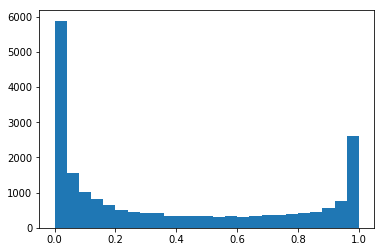

In [148]:
##モデルパラメータを生成
#単語の埋込ベクトルを生成
mu = np.random.normal(-0.25, 1.0, k)
theta = np.random.multivariate_normal(mu, np.diag(np.repeat(9.0, k)), v)
beta = np.array([-1.0])
betat = beta.copy(); thetat = theta.copy()

#文書ごとの単語を生成
m = 50
gamma = np.random.dirichlet(np.repeat(0.1, m), D)
phi = np.random.dirichlet(np.repeat(0.1, v), m)
z = np.dot(np.array(rmnom(gamma[w_id, ], f, m, np.arange(f)).todense()), np.arange(m))
wd_list = [i for i in range(D)]
for i in range(D):
    wd_list[i] = np.array(np.dot(rmnom(phi[z[id_list[i]], ], w[i], v, np.arange(w[i])).todense(), np.arange(v))).reshape(-1)
wd = np.array(list(itertools.chain(*[wd_list[i] for i in range(D)])))

##2文書間のマッチング有無を生成
#2文書間の距離をカーネル関数で表現
w_sq = np.repeat(0, N)
distance = np.repeat(0.0, N)
for i in range(N):    
    id1 = d_id1[i]; id2 = d_id2[i]
    theta_d1 = theta[wd_list[id1], ]
    theta_d2 = theta[wd_list[id2], ]
    w_sq[i] = w[id1]*w[id2]
    distance[i] = np.sum(np.dot(theta_d1, theta_d2.T)) / (w[id1]*w[id2])
    
#ベルヌーイ分布から応答変数を生成
logit = beta + (distance - np.mean(distance))
Prob = np.exp(logit) / (1 + np.exp(logit))
y = np.random.binomial(1, Prob, N)
y_vec = y[:, np.newaxis]

#生成した応答変数を確認
print(np.mean(y))
print(np.std(distance))
plt.hist(Prob, bins=25)

In [149]:
np.sum(np.dot(theta_d1, theta_d2.T)) 
w_sq[i]


480

In [150]:
####最尤法でパラメータを推定####
##パラメータを推定するための関数
#対数尤度関数を計算する関数
def loglike(theta, tau, y, wd1, wd2, wd_list, wd_list1, wd_list2, d_id1, d_id2, allocation_id1, allocation_id2, w_sq, N, v, k):
    #パラメータの設定
    beta = theta[0]
    theta_d = theta[1:].reshape(v, k)
    
    #文書間のカーネル埋め込みを定義
    distance = np.repeat(0.0, N)
    for i in range(N):   
        id1 = d_id1[i]; id2 = d_id2[i]
        theta_d1 = theta_d[wd_list[id1], ]
        theta_d2 = theta_d[wd_list[id2], ]
        distance[i] = np.sum(np.dot(theta_d1, theta_d2.T)) / (w_sq[i])

    #ベルヌーイ分布から応答変数を生成
    logit = beta + distance
    Prob = np.exp(logit) / (1 + np.exp(logit))

    #対数尤度の和
    penalty = -1/2 * np.sum(np.power(theta_d, 2) / tau)
    LL = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
    LLho = -(LL + penalty)
    return LLho 

In [151]:
##対数尤度関数の勾配ベクトル
def dloglike(theta, tau, y, wd1, wd2, wd_list, wd_list1, wd_list2, d_id1, d_id2, allocation_id1, allocation_id2, w_sq, N, v, k):
    #パラメータの設定
    beta = theta[0]
    theta_d = theta[1:].reshape(v, k)

    #文書間のカーネル埋め込みを定義
    theta_x1 = np.zeros((N, k))
    theta_x2 = np.zeros((N, k))
    distance = np.repeat(0.0, N)
    for i in range(N):   
        id1 = d_id1[i]; id2 = d_id2[i]
        theta_d1 = theta_d[wd_list[id1], ]
        theta_d2 = theta_d[wd_list[id2], ]
        theta_x1[i, ] = np.sum(theta_d2, axis=0)
        theta_x2[i, ] = np.sum(theta_d1, axis=0)
        distance[i] = np.sum(np.dot(theta_d1, theta_d2.T)) / (w_sq[i])

    #ベルヌーイ分布から応答変数を生成
    logit = beta + distance 
    Prob = np.exp(logit) / (1 + np.exp(logit))   

    #勾配ベクトルの和
    x1 = (distance[allocation_id1] / w_sq[allocation_id1])[:, np.newaxis] * theta_x1[allocation_id1, ]
    x2 = (distance[allocation_id2] / w_sq[allocation_id2])[:, np.newaxis] * theta_x2[allocation_id2, ]
    gradient1 = y[allocation_id1][:, np.newaxis]*x1 - Prob[allocation_id1][:, np.newaxis] *x1
    gradient2 = y[allocation_id2][:, np.newaxis]*x2 - Prob[allocation_id2][:, np.newaxis] *x2
    gradient = np.zeros((v, k))
    for j in range(v):
        gradient[j, ] = np.sum(gradient1[wd_list1[j], ], axis=0) + np.sum(gradient2[wd_list2[j], ], axis=0)
    dlogit = -np.append(np.sum(y - Prob), gradient.reshape(-1) - theta_d.reshape(-1) / tau)
    return dlogit

In [143]:
##すべての文書組み合わせにおける単語ベクトル
#データの格納用配列
wd_list1 = [i for i in range(N)]
wd_list2 = [i for i in range(N)]
allocation_list1 = [i for i in range(N)]
allocation_list2 = [i for i in range(N)]

#文書のインデックスを作成
for i in range(N):
    wd_list1[i] = wd_list[d_id1[i]]
    wd_list2[i] = wd_list[d_id2[i]]
    allocation_list1[i] = np.repeat(i, wd_list1[i].shape[0])
    allocation_list2[i] = np.repeat(i, wd_list2[i].shape[0])

#リストに変換
wd1 = np.array(list(itertools.chain(*[wd_list1[i] for i in range(N)])))
wd2 = np.array(list(itertools.chain(*[wd_list2[i] for i in range(N)])))
allocation_id1 = np.array(list(itertools.chain(*[allocation_list1[i] for i in range(N)])))
allocation_id2 = np.array(list(itertools.chain(*[allocation_list2[i] for i in range(N)])))
del wd_list1, wd_list2, allocation_list1, allocation_list2

#単語のインデックスを作成
wd_list1 = [j for j in range(v)]
wd_list2 = [j for j in range(v)]
for j in range(v):
    wd_list1[j] = np.array(np.where(wd1==j)[0], dtype="int")
    wd_list2[j] = np.array(np.where(wd2==j)[0], dtype="int")

In [144]:
##準ニュートン法でパラメータを推定
#初期値と正則化パラメータを設定
tau = np.array([2.0])
theta = np.append(-1.0, np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.5, k)), v).reshape(-1))
res = optimize.minimize(loglike, theta, jac=dloglike, method='CG', args=(tau, y, wd1, wd2, wd_list, wd_list1, wd_list2,
                                                                           d_id1, d_id2, allocation_id1, allocation_id2, w_sq, N, v, k),
                        options={"gtol":0.1, "disp":True})

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


         Current function value: 14167.004204
         Iterations: 3
         Function evaluations: 45
         Gradient evaluations: 34


In [145]:
loglike(theta, tau, y, wd1, wd2, wd_list, wd_list1, wd_list2, d_id1, d_id2, allocation_id1, allocation_id2, w_sq, N, v, k)

14840.88088498637

In [79]:
theta_vec = np.append(betat, thetat.reshape(-1))
LLbest = loglike(theta_vec, tau, y, wd1, wd2, wd_list, wd_list1, wd_list2, d_id1, d_id2, allocation_id1, allocation_id2, w_sq, N, v, k)
LLbest

191526.00679736835